In [1]:
import numpy as np
import nibabel as nib
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

In [2]:
image_path = '/Users/zhujiayuan/Downloads/Task04_Hippocampus/imagesTr/hippocampus_001.nii.gz'
image_obj = nib.load(image_path)
print(f'Type of the image {type(image_obj)}.')

Type of the image <class 'nibabel.nifti1.Nifti1Image'>.


In [3]:
# Turn into numpy array
#array = np.array(image.dataobj)
image_data = image_obj.get_fdata()
type(image_data)

numpy.ndarray

In [6]:
image_data.shape

(35, 51, 35)

In [7]:
# Get the image shape and print it out
height, width, depth= image_data.shape
print(f'The image object has the following dimensions:\nheight={height}\nwidth={width}\ndepth={depth}')

The image object has the following dimensions:
height=35
width=51
depth=35


### Visualize

Plotting layer Layer 17 of image


<function matplotlib.pyplot.show(close=None, block=None)>

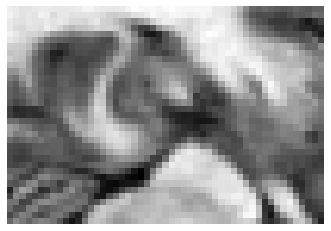

In [13]:
# Select random layer number
maxval = 35
i = np.random.randint(0, maxval)

print(f'Plotting layer Layer {i} of image')
plt.imshow(image_data[:, :, i], cmap = 'gray')
plt.axis('off')
plt.show

In [14]:
# define a function to visualize the data
def explore_3d_image(layer):
    plt.figure(figsize=(10,15))
    plt.imshow(image_data[:, :, layer], cmap = 'gray')
    plt.title('Explore Layers of Brain MRI', family = 'Arial', fontsize=20)
    plt.axis('off')
    return layer

# run the ipywidgets interact() function to explore data
interact(explore_3d_image, layer=(0,image_data.shape[2]-1))

interactive(children=(IntSlider(value=17, description='layer', max=34), Output()), _dom_classes=('widget-inter…

<function __main__.explore_3d_image(layer)>

In [18]:
label_path = '/Users/zhujiayuan/Downloads/Task04_Hippocampus/labelsTr/hippocampus_001.nii.gz'
label_obj = nib.load(label_path)
type(label_obj)

nibabel.nifti1.Nifti1Image

In [19]:
label_array = label_obj.get_fdata()
type(label_array)

numpy.ndarray

In [20]:
height,width,depth=label_array.shape
print(f'The label object has the following dimensions:\nheight={height}\nwidth={width}\ndepth={depth}')

The label object has the following dimensions:
height=35
width=51
depth=35


In [26]:
print(f'With the unique values: {np.unique(label_array)}')

print('''\nCorresponding to the following label categories
0: background,
1: Anterior,
2: Posterior
''')

With the unique values: [0. 1. 2.]

Corresponding to the following label categories
0: background,
1: Anterior,
2: Posterior



### visualize the data for specific labels

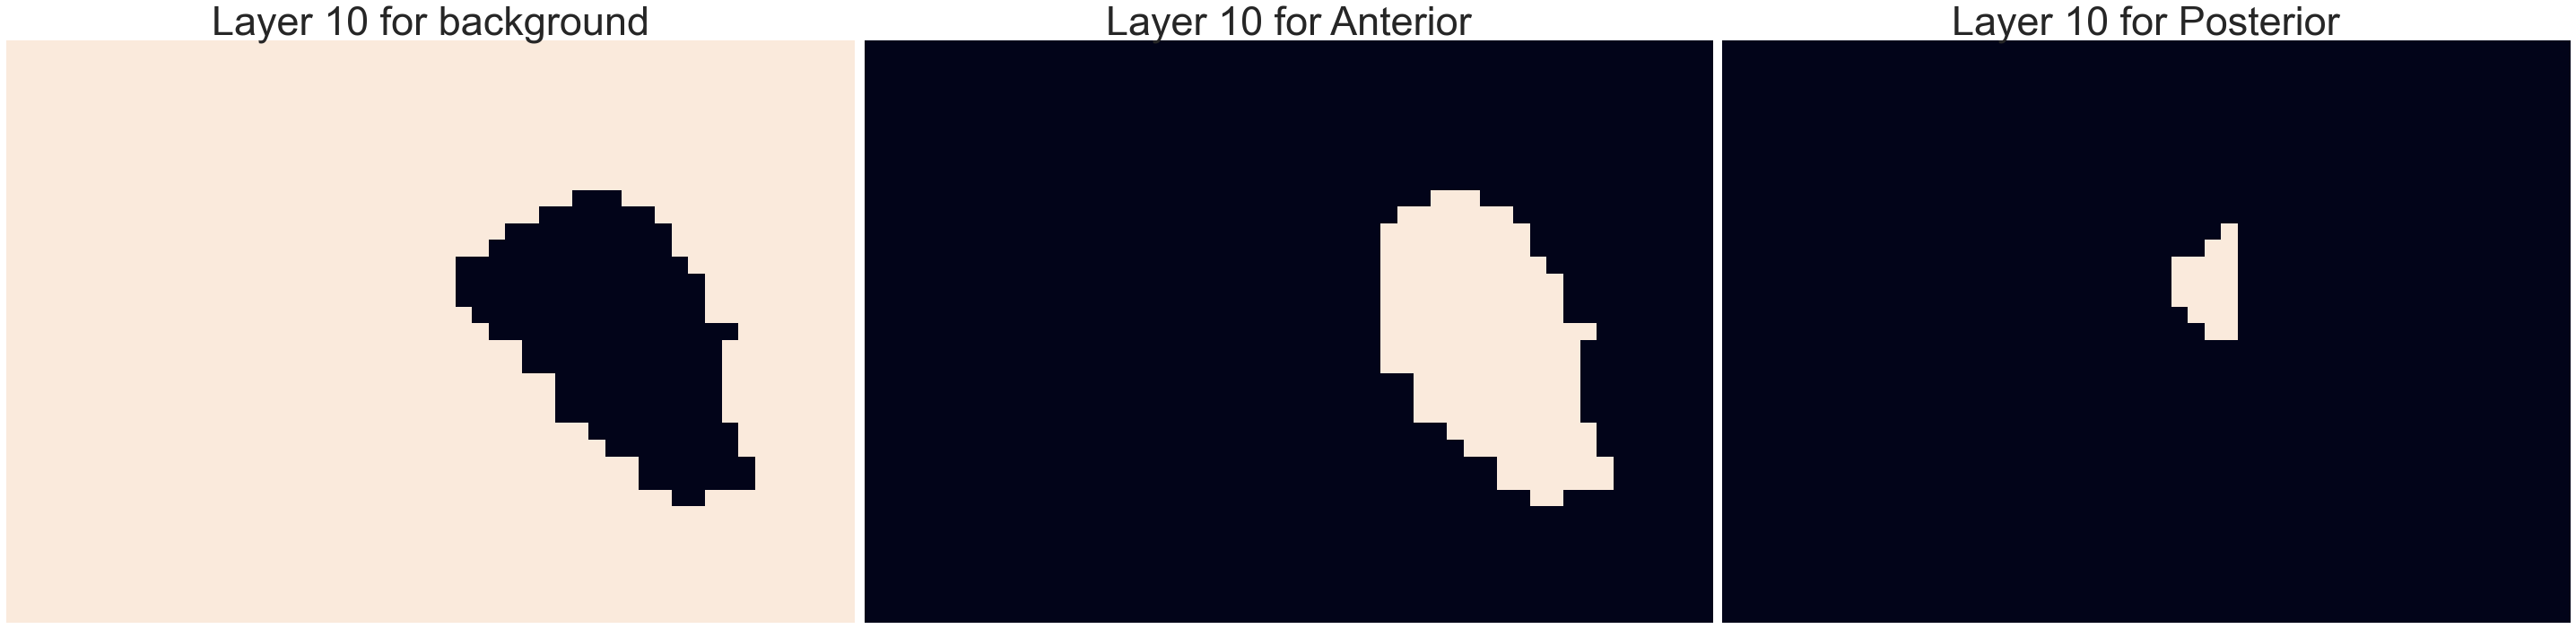

In [73]:
# define a single layer for plotting
layer = 10

# define a dictionary of class labels
classes_dict = {
    'background': 0,
    'Anterior':1,
    'Posterior': 2
}

# set up for plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(40,25))
for i in range(3):
    img_label_str = list(classes_dict.keys())[i]
    img = label_array[:, :, layer]
    mask = np.where(img==classes_dict[img_label_str], 255, 0)
    ax[i].imshow(mask)
    ax[i].set_title(f'Layer {layer} for {img_label_str}', fontsize=45, family = 'Arial')
    ax[i].axis('off')
plt.tight_layout()

### interactive visualization across layers

In [78]:
# create button values
select_class = ToggleButtons(
    options = ['background', 'Anterior', 'Posterior'],
    description = 'Select class',
    disabled = False,
    button_style = 'info'
)

# create layer slider
select_layer = IntSlider(min=0, max = 34, description = 'Select layer', continuous_update = False)

# define a function for plotting images
def plot_image(seg_class, layer):
    print(f'Plotting {layer} Layer, Label: {seg_class}')
    img_label = classes_dict[seg_class]
    mask = np.where(label_array[:, :, layer]==img_label, 255, 0)
    plt.figure(figsize=(6,9))
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    
# use the interactive() tool to create a visualization
interactive(plot_image, seg_class = select_class, layer = select_layer)


interactive(children=(ToggleButtons(button_style='info', description='Select class', options=('background', 'A…

## import data

In [182]:
import glob
import torchio as tio
from torchvision import transforms 
from torch.utils.data import DataLoader

In [152]:
images = glob.glob('/Users/zhujiayuan/Downloads/Task04_Hippocampus/imagesTr' + "/*.nii.gz")
labels = glob.glob('/Users/zhujiayuan/Downloads/Task04_Hippocampus/labelsTr' + "/*.nii.gz")

### find maximum size

In [181]:
max_width = 0
max_height = 0
max_depth = 0
for i in range(len(images)):
    image = nib.load(images[i]).get_fdata().shape
    label = nib.load(labels[i]).get_fdata().shape
    if image[0] > max_width or label[0] > max_width:
        max_width = max(image[0], label[0])
    if image[1] > max_height or label[1] > max_height:
        max_height = max(image[1], label[1])
    if image[2] > max_depth or label[2] > max_depth:
        max_depth = max(image[2], label[2])
        
resize_shape = (max_width, max_height, max_depth)
resize_shape

(43, 59, 47)

In [164]:
nib.load(images[0]).get_fdata().shape

(36, 57, 37)

In [211]:
resize_shape

(43, 59, 47)

### resize image with tio.CropOrPad

In [200]:
# Load data and include prepared transform (Remember to apply same transform to both image and label) 
class mySegmentationData(object):
    def __init__(self, images, labels, resize_shape, transforms = None):
        self._eval = eval
        self._images = images
        self._labels = labels
        self.resize_shape = resize_shape
        self.transforms = transforms
                      
    
    def __getitem__(self, idx):
        image = tio.ScalarImage(self._images[idx])
        label = tio.ScalarImage(self._labels[idx])
        transform = tio.CropOrPad(self.resize_shape)
        image = transform(image).data
        label = transform(image).data
        
        if self.transforms is not None:
            image = self.transforms(image)
            label = self.transforms(label)
   
        return image, label
    
    def __len__(self):
        return len(self._images)

In [201]:

trainset = mySegmentationData(images, labels, resize_shape)

#  same as you did in classification (here we are doing )
from torch.utils.data.sampler import SubsetRandomSampler
val_percentage = 0.2
num_train = len(trainset)

indices = list(range(num_train))
split = int(np.floor(val_percentage * num_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


print(len(train_sampler))

# Now create data loaders (same as before)
# Now we need to create dataLoaders that will allow to iterate during training
batch_size = 4 # create batch-based on how much memory you have and your data size

traindataloader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=0)
valdataloader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler,
            num_workers=0)



208


In [202]:
print('Number of training samples:', len(traindataloader))
print('Number of validation samples:', len(valdataloader))

Number of training samples: 52
Number of validation samples: 13


In [235]:
# always check the shape of your training data
dataiter = iter(traindataloader)
images, masks = next(dataiter)
images.shape

torch.Size([4, 1, 43, 59, 47])

Plotting layer Layer 10 of image


<function matplotlib.pyplot.show(close=None, block=None)>

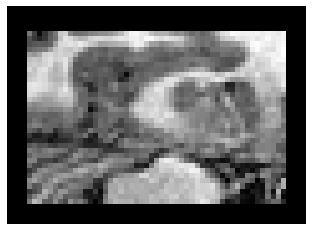

In [254]:
i = 10
print(f'Plotting layer Layer {i} of image')
plt.imshow(images[3, 0, :, :, 15], cmap = 'gray')
plt.axis('off')
plt.show

In [241]:
j = masks[:,:,:,:,10]

In [242]:
import torchvision 
def test_imshow(img):
    # TODO: unnormalize if needed
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


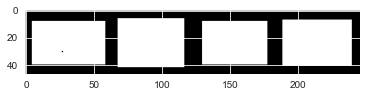

In [243]:
test_imshow(torchvision.utils.make_grid(j))

In [111]:
b = tio.ScalarImage(data[0])

In [112]:
b

ScalarImage(shape: (1, 36, 57, 37); spacing: (1.00, 1.00, 1.00); orientation: RAS+; path: "/Users/zhujiayuan/Downloads/Task04_Hippocampus/imagesTr/hippocampus_367.nii.gz")

In [113]:
transform = tio.CropOrPad((36,36,36))
output = transform(b)
output

ScalarImage(shape: (1, 36, 36, 36); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 182.2 KiB)

In [125]:
output.data[0].shape

torch.Size([36, 36, 36])

In [180]:
output.data[0]

tensor([[[ 464.7552,  652.2880,  741.9776,  ...,  627.8272,  513.6768,
           399.5264],
         [ 513.6768,  546.2912,  635.9808,  ...,  546.2912,  456.6016,
           293.5296],
         [ 505.5232,  472.9088,  538.1376,  ...,  513.6768,  432.1408,
           350.6048],
         ...,
         [ 407.6800,  350.6048,  432.1408,  ...,  366.9120,  366.9120,
           375.0656],
         [ 317.9904,  391.3728,  391.3728,  ...,  244.6080,  252.7616,
           375.0656],
         [ 326.1440,  423.9872,  366.9120,  ...,   89.6896,  252.7616,
           228.3008]],

        [[ 423.9872,  489.2160,  464.7552,  ...,  554.4448,  415.8336,
           309.8368],
         [ 464.7552,  497.3696,  415.8336,  ...,  464.7552,  326.1440,
           285.3760],
         [ 472.9088,  448.4480,  423.9872,  ...,  358.7584,  415.8336,
           472.9088],
         ...,
         [ 391.3728,  391.3728,  358.7584,  ...,  260.9152,  220.1472,
           260.9152],
         [ 366.9120,  407.6800,  350.604